In [2]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

In [3]:
from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [4]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors 

import matplotlib.animation as animation
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from src import ket as ket
from src import density_matrix as DM

In [ ]:
#Load data

In [4]:
import sys as SYS; SYS.path.insert(0, '../..')
from Scripts import hdf5merge
hdf5merge.merge_hdf5_files("../data/landscape_maximizes")

In [25]:
newdata1 = h5py.File("../data/random/random.hdf5")
newdata2 = h5py.File("../data/greedy/greedy.hdf5")
newdata3 = h5py.File("../data/mimic/mimic.hdf5")
newdata4 = h5py.File("../data/landscape_maximizes/landscape_maximizes.hdf5")

In [26]:
def get_pops(data, n_qubits, connectivity,update_rule):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['pops'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity,update_rule):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 1'][f'unitary seed {seed}'][f'ordering seed {update_rule}']['two_qubit_dms'])
        dat = {int(k.split('(')[0]): dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [ ]:
#Only run if you want to see the format of the data

In [ ]:
def print_hdf5_structure(file_path):
    with h5py.File(file_path, 'r') as file:
        def print_group(name, obj):
            if isinstance(obj, h5py.Group):
                print(f'Group: {name}')
                for key in obj.keys():
                    print(f'  {key}')
            elif isinstance(obj, h5py.Dataset):
                print(f'Dataset: {name}')

        file.visititems(print_group)

# Replace with the path to your merged HDF5 file
file_path = '../data/random/random.hdf5'  
print_hdf5_structure(file_path)

In [ ]:
#Code that locates the choice of neighbourhoods 

In [7]:
import h5py
def load_orders_list(file_path: str, num_qubits, connectivity, unitary_energy_subspace, unitary_seed, order_rule_name: str):
    # Create an empty dictionary to hold orders_list
    orders_list = []

    with h5py.File(file_path, 'r') as file:
        # Construct the path to the specific group where orders_list is stored
        group_name = f"{num_qubits} qubits/{connectivity} connectivity/unitary energy subspace {unitary_energy_subspace}/unitary seed {unitary_seed}/ordering seed {order_rule_name}/previous_order"
        
        # Check if the group exists
        if group_name in file:
            group = file[group_name]
            for time_index in group:
                # Assuming the order data is stored in a dataset named 'data'
                orders_list.append(group[time_index]['data'][()])
        else:
            print(f"Group '{group_name}' not found in file.")
    
    return orders_list


In [ ]:
#Example of extracting data using above code. This will give a list of array of arrays where each array
#is a complete K2 selection of connectivity on the network

In [22]:
# Set your parameters
file_path = "../data/landscape_maximizes/landscape_maximizes.hdf5"  # Path to your combined HDF5 file
num_qubits = 8
connectivity = 'cN_2local'  # Replace with actual connectivity value
unitary_energy_subspace = '1'  # Replace with actual value
unitary_seed = '0'  # Replace with actual value
order_rule_name = 'landscape_maximizes'  # Replace with actual rule

# Load orders_list
orders_list = load_orders_list(file_path, num_qubits, connectivity, unitary_energy_subspace, unitary_seed, order_rule_name)
orders_list[0][492]
# Print the loaded orders_list

array([[0, 7],
       [4, 5],
       [1, 3],
       [2, 6]])

In [ ]:
#Emergent graph for a particular simulation given by the "unitary seed" for a given size system with given rule. 
#Note that this gives the total emergent graph and no information about the temporal evolution.

In [29]:
num_qubits=8
conn="cN_2local"
unitary_seed=5
#for conn in ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]:
output_random= load_orders_list("../data/random/random.hdf5", num_qubits, conn, 1, unitary_seed, 'random')
output_random[0];
#for conn in ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]:
output_greedy=load_orders_list("../data/greedy/greedy.hdf5", num_qubits, conn, 1, unitary_seed, 'greedy')
output_greedy[0];
#for conn in ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]:
output_mimic=load_orders_list("../data/mimic/mimic.hdf5", num_qubits, conn, 1, unitary_seed, 'mimic')
output_mimic[0];
#for conn in ["c2_2local","c4_2local","c5_2local","c6_2local","cN_2local"]:
output_landscape_maximizes= load_orders_list("../data/landscape_maximizes/landscape_maximizes.hdf5", num_qubits, conn, 1, unitary_seed, 'landscape_maximizes')
#output_landscape_maximizes[0];

In [ ]:
#Make a network based on the (probability )number of times a particular neighbourhood is chosen out of 1. 
#This is good for probability measures

Adjacency Matrix for Random Node Pairs:
[[ 0. 72. 55. 76. 73. 83. 79. 61.]
 [72.  0. 76. 75. 59. 65. 75. 77.]
 [55. 76.  0. 75. 69. 78. 58. 88.]
 [76. 75. 75.  0. 75. 57. 76. 65.]
 [73. 59. 69. 75.  0. 85. 77. 61.]
 [83. 65. 78. 57. 85.  0. 59. 72.]
 [79. 75. 58. 76. 77. 59.  0. 75.]
 [61. 77. 88. 65. 61. 72. 75.  0.]]

Adjacency Matrix for Greedy Node Pairs:
[[ 0. 77. 70. 56. 86. 73. 63. 74.]
 [77.  0. 63. 62. 60. 77. 75. 85.]
 [70. 63.  0. 76. 70. 76. 76. 68.]
 [56. 62. 76.  0. 71. 79. 78. 77.]
 [86. 60. 70. 71.  0. 53. 85. 74.]
 [73. 77. 76. 79. 53.  0. 71. 70.]
 [63. 75. 76. 78. 85. 71.  0. 51.]
 [74. 85. 68. 77. 74. 70. 51.  0.]]

Adjacency Matrix for Mimic Node Pairs:
[[  0. 269.  38.  15.  50.  83.  15.  29.]
 [269.   0.  37.  29.  35.  48.  43.  38.]
 [ 38.  37.   0.  57.  27. 120. 172.  48.]
 [ 15.  29.  57.   0. 135.  56.  67. 140.]
 [ 50.  35.  27. 135.   0.  38. 137.  77.]
 [ 83.  48. 120.  56.  38.   0.  26. 128.]
 [ 15.  43. 172.  67. 137.  26.   0.  39.]
 [ 29.  38.  48.

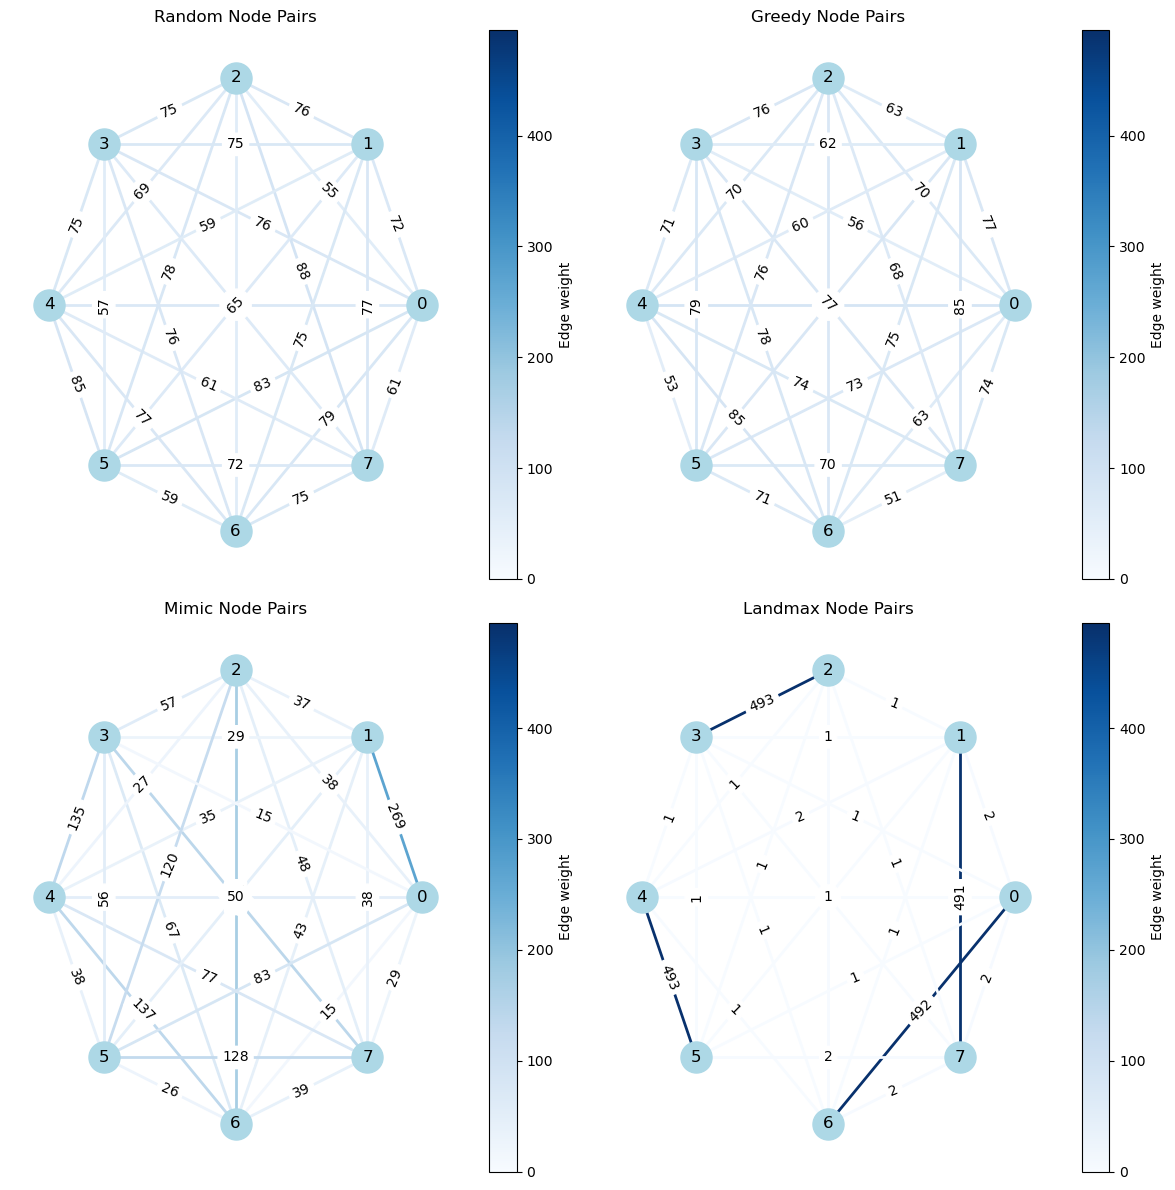

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.cm as cm
import numpy as np

# Example: four different datasets of node pairs (replace with your real data)
datasets = [output_random[0][0:], output_greedy[0][0:], output_mimic[0][0:], output_landscape_maximizes[0][0:]]  # Replace these with your actual datasets
dataset_titles = ["Random Node Pairs", "Greedy Node Pairs", "Mimic Node Pairs", "Landmax Node Pairs"]

# Function to visualize each dataset
def visualize_network(dataset, ax, title, pos, cmap):
    # Flatten the dataset into a list of tuples representing pairs
    edges = [tuple(sorted(pair)) for sublist in dataset for pair in sublist]
    vmin=0
    vmax=495

    # Count the number of times each node pair appears
    edge_weights = Counter(edges)

    # Create a graph
    G = nx.Graph()

    # Add edges along with their weights
    for edge, weight in edge_weights.items():
        G.add_edge(edge[0], edge[1], weight=weight)

    edges = list(G.edges)

    # Get the edge weights to visualize them
    weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

    # Normalize weights for color mapping
    norm = plt.Normalize(vmin, vmax)

    # Map edge weights to colors using the given colormap
    edge_colors = [cmap(norm(w)) for w in weights]

    # Draw the graph with node labels, use color to represent the weight
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500,
            edge_color=edge_colors, width=2, ax=ax)

    # Draw edge labels to show weights
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)}, ax=ax)

    # Add a color bar to show the weight scale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Edge weight")

    # Add a title to each subplot
    ax.set_title(title)

    n_nodes = max(max(edge) for edge in edges) + 1  # Ensure it covers all nodes
    adj_matrix = np.zeros((n_nodes, n_nodes))

    for (edge, weight) in zip(edges, weights):
        adj_matrix[edge[0], edge[1]] = weight
        adj_matrix[edge[1], edge[0]] = weight
    print(f"Adjacency Matrix for {title}:\n{adj_matrix}\n")
    return adj_matrix
# Define the layout and figure for the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # 2x2 grid of subplots

# Generate a consistent node position layout across all datasets
# Flatten the datasets to extract individual nodes, assuming each sublist contains node pairs
all_nodes = set([node for dataset in datasets for sublist in dataset for pair in sublist for node in pair])
G_all = nx.Graph()
G_all.add_nodes_from(all_nodes)
pos = nx.circular_layout(G_all)  # Fixed layout for nodes

# Colormaps for each dataset (optional: you can change these)
colormaps = [cm.Blues, cm.Blues, cm.Blues, cm.Blues]

# Store adjacency matrices for further processing
adjacency_matrices = []

# Visualize each dataset in its respective subplot and output the adjacency matrix
for i, dataset in enumerate(datasets):
    row, col = divmod(i, 2)
    adj_matrix = visualize_network(dataset, axs[row, col], dataset_titles[i], pos, colormaps[i])
    #store all adjacency matrices in a list
    adjacency_matrices.append(adj_matrix)  # Store the matrix in a list

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Further processing with adjacency_matrices if needed
# Now adjacency_matrices is a list of NumPy arrays



In [15]:
adjacency_matrices[3]

array([[  0.,   0.,   1.,   0.,   1., 493.,   3.,   1.],
       [  0.,   0.,   1.,   2., 493.,   1.,   0.,   2.],
       [  1.,   1.,   0.,   1.,   1.,   0.,   2., 493.],
       [  0.,   2.,   1.,   0.,   3.,   1., 492.,   0.],
       [  1., 493.,   1.,   3.,   0.,   1.,   0.,   0.],
       [493.,   1.,   0.,   1.,   1.,   0.,   1.,   2.],
       [  3.,   0.,   2., 492.,   0.,   1.,   0.,   1.],
       [  1.,   2., 493.,   0.,   0.,   2.,   1.,   0.]])

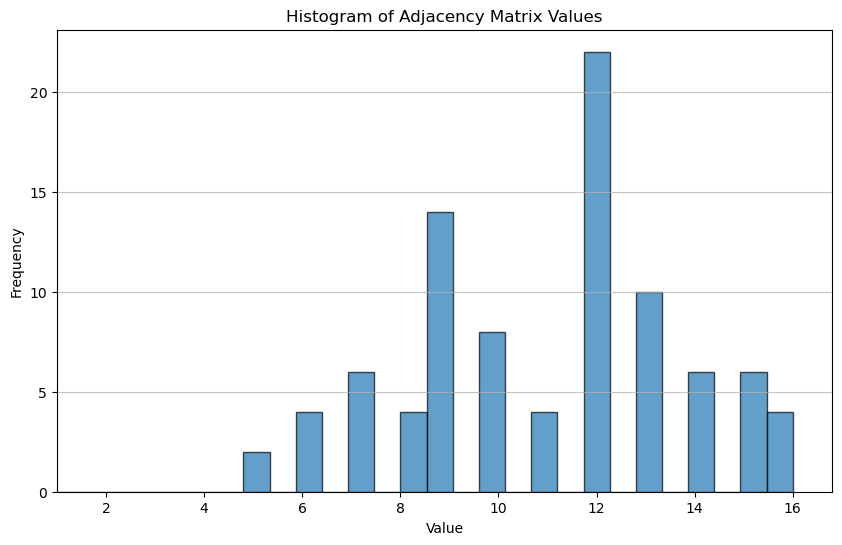

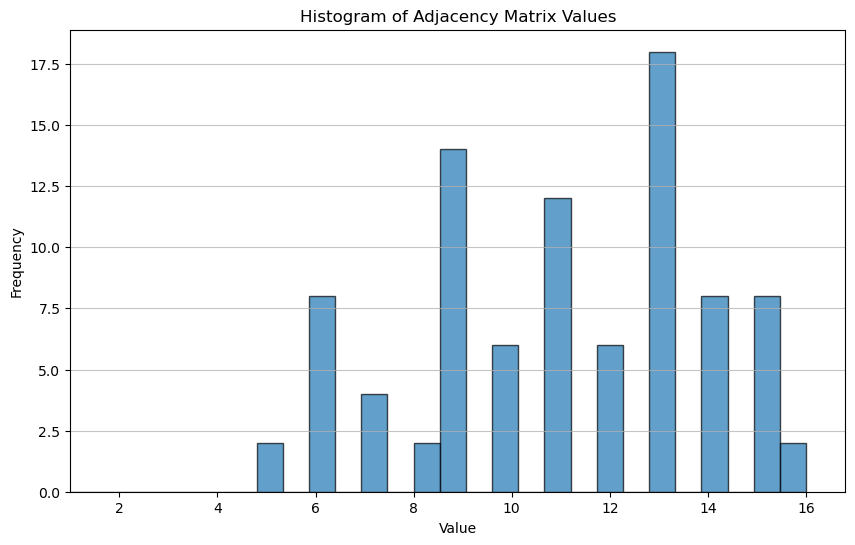

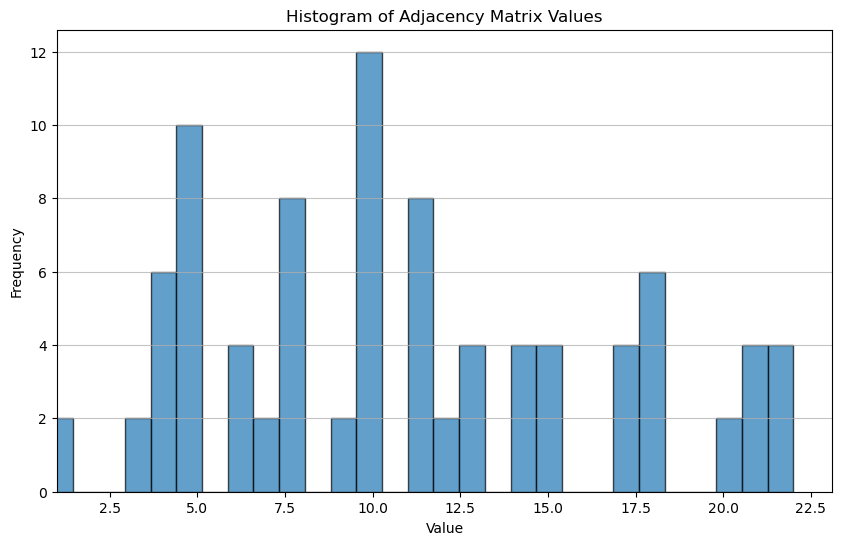

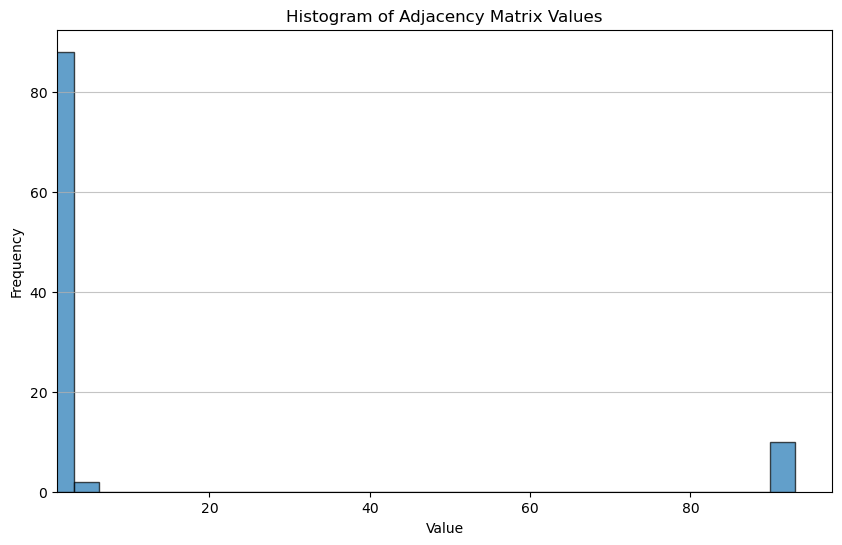

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you have your adjacency matrix as a NumPy array
# For example, you can use the first adjacency matrix from your previous computation
for adj_mat in [adjacency_matrices[0],adjacency_matrices[1],adjacency_matrices[2],adjacency_matrices[3]]:
    adjacency_matrix = adj_mat  # Replace with your desired adjacency matrix
    
    # Step 1: Flatten the adjacency matrix to a 1D array
    flattened_values = adjacency_matrix.flatten()
    #plt.xlim(left=1)  # Start x-axis from 1
    # Step 2: Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(flattened_values, bins=30, edgecolor='black', alpha=0.7)
    plt.xlim(left=1)  # Start x-axis from 1
    plt.title('Histogram of Adjacency Matrix Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assume you have your adjacency matrix as a NumPy array
# For example, using the first adjacency matrix from your previous computation
for adj_mat in [adjacency_matrices[0], adjacency_matrices[1], adjacency_matrices[2], adjacency_matrices[3]]:
    adjacency_matrix = adj_mat  # Replace with your desired adjacency matrix
    
    # Step 1: Flatten the adjacency matrix to a 1D array
    flattened_values = adjacency_matrix.flatten()
    
    # Step 2: Plot the histogram
    plt.figure(figsize=(10, 6))
    count, bins, ignored = plt.hist(flattened_values, bins=30, density=True, edgecolor='black', alpha=0.7)

    # Step 3: Fit the data to a normal distribution and plot the best fit curve
    mu, std = norm.fit(flattened_values)  # Mean and standard deviation of the best fit
    xmin, xmax = plt.xlim()  # Get the x-axis limits
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)  # Gaussian probability density function
    plt.plot(x, p, 'k', linewidth=2)  # Plot the fitted curve

    # Labels and title
    plt.title(f'Histogram and Best Fit Curve (mu = {mu:.2f}, std = {std:.2f})')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.grid(axis='y', alpha=0.75)
    plt.show()


In [ ]:
def cluster_coeff(adj_mat):
    adj_mat=np.array(adj_mat)
    M_sq = adj_mat@adj_mat
    sum_of_M_sq = np.sum(M_sq)
    M_cube = adj_mat@adj_mat@adj_mat
    M_cube_trace = np.trace(M_cube)
    return M_cube_trace/sum_of_M_sq

In [ ]:
Averaging by looking at spectral property 

In [40]:
import numpy as np
import networkx as nx
from scipy.linalg import eigh

# Assume adjacency_matrices contains the adjacency matrices for your graphs
# Ensure that they are square matrices
graphs = [nx.from_numpy_array(adj) for adj in adjacency_matrices]

# Step 1: Compute the Laplacian for each graph
laplacians = [nx.laplacian_matrix(g).toarray() for g in graphs]

# Step 2: Compute eigenvalues and eigenvectors for each Laplacian
eigenvalues = []
eigenvectors = []
for lap in laplacians:
    eigvals, eigvecs = eigh(lap)  # eigh for symmetric matrices
    eigenvalues.append(eigvals)
    eigenvectors.append(eigvecs)

# Step 3: Average the eigenvalues and eigenvectors
avg_eigenvalues = np.mean(eigenvalues, axis=0)  # Average eigenvalues
avg_eigenvectors = np.mean(eigenvectors, axis=0)  # Average eigenvectors

# Step 4: Reconstruct the Laplacian from averaged eigenvalues/vectors (optional)
L_avg = avg_eigenvectors @ np.diag(avg_eigenvalues) @ avg_eigenvectors.T

# Convert the averaged Laplacian back to an adjacency matrix (optional)
D_avg = np.diag(np.sum(L_avg, axis=1))  # Reconstruct degree matrix
A_avg = D_avg - L_avg  # Reconstruct adjacency matrix

# Convert the adjacency matrix back to a networkx graph (optional)
G_avg = nx.from_numpy_array(A_avg)

# Output the average eigenvalues and the reconstructed graph (optional)
print("Average Eigenvalues:", avg_eigenvalues)
print("Average Laplacian:\n", L_avg)
print("Reconstructed Adjacency Matrix:\n", A_avg)


Average Eigenvalues: [4.61852778e-14 7.13413625e+01 7.50037897e+01 7.76544621e+01
 8.05312708e+01 1.28261615e+02 1.34124959e+02 1.37226129e+02
 1.40739598e+02 1.45116814e+02]
Average Laplacian:
 [[  9.33603638   3.85429213  -1.12657376  -3.30231875  -3.32239658
   -8.64063631  -2.34661785   6.25127228   4.17452607  -4.87758362]
 [  3.85429213  11.53572544  -3.39913207  -2.40699092  -5.84950113
  -12.28695232  -3.73364467   6.75417633  15.02369397  -9.49166677]
 [ -1.12657376  -3.39913207   7.25330355  -3.32971468   3.13641095
   -0.76633491  -9.79765262   3.76483052  -1.14197962   5.40684264]
 [ -3.30231875  -2.40699092  -3.32971468   7.51940557   0.44948258
    8.50255465   1.93654145  -4.46512182  -8.79346984   3.88963174]
 [ -3.32239658  -5.84950113   3.13641095   0.44948258  22.90847097
    8.18470477  -6.93445005  -7.82413127 -16.14710838   5.39851813]
 [ -8.64063631 -12.28695232  -0.76633491   8.50255465   8.18470477
   28.27028086   4.35074503 -14.32236324 -21.21664591   7.92464

In [83]:
from scipy.linalg import eigh

laplacians = [nx.laplacian_matrix(G).toarray()]

# Step 2: Compute eigenvalues and eigenvectors for each Laplacian
eigenvalues = []
eigenvectors = []
for lap in laplacians:
    eigvals, eigvecs = eigh(lap)  # eigh for symmetric matrices
    eigenvalues.append(eigvals)
    eigenvectors.append(eigvecs)
eigenvalues

[array([4.44089210e-16, 6.74219290e-02, 8.09973986e-02, 9.18479945e-02,
        1.18474816e-01, 1.87063284e+00, 1.89531498e+00, 1.91155701e+00,
        1.92209578e+00, 1.94165725e+00])]

In [85]:
laplacians = [nx.laplacian_matrix(G).toarray()]

# Step 2: Compute eigenvalues and eigenvectors for each Laplacian
eigenvalues = []
eigenvectors = []
for lap in laplacians:
    eigvals, eigvecs = eigh(lap)  # eigh for symmetric matrices
    eigenvalues.append(eigvals)
    eigenvectors.append(eigvecs)
eigenvalues

[array([-2.22044605e-16,  9.57102241e-01,  1.01553299e+00,  1.03842978e+00,
         1.06201399e+00,  1.09922780e+00,  1.13581319e+00,  1.14099226e+00,
         1.20574813e+00,  1.24513963e+00])]

In [ ]:
#Plot the laplacians
import matplotlib.pyplot as plt

# Example data (four lists of N points)
N = 10
x = list(range(N))  # X-axis points (0, 1, 2, ..., N-1)
y1 = average_laplacian_eigenvalues(np.array(MI_adj_random))[1]    # First list of N points
y2 = average_laplacian_eigenvalues(np.array(MI_adj_greedy))[1]   # Second list
y3 = average_laplacian_eigenvalues(np.array(MI_adj_mimic))[1]  # Third list
y4 = average_laplacian_eigenvalues(np.array(MI_adj_landmax))[1]  # Fourth list

# Plot each list on the same chart
plt.plot(x, y1, label='List 1', marker='o')  # Plot with markers
plt.plot(x, y2, label='List 2', marker='x')
plt.plot(x, y3, label='List 3', marker='s')
plt.plot(x, y4, label='List 4', marker='d')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of 4 Lists on the Same Chart')

# Add a legend to distinguish between the lists
plt.legend()

# Show the plot
plt.show()